# Top-Rank Recommendations Using Deep Learning<a class='anchor' id='top'></a>

A copy of this notebook can be found here: https://github.com/jaworXYZ/5511-FINAL/blob/main/M6-DeepReco.ipynb

This project uses the [Book-Crossing Dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). The data was gathered from the Book Crossing website and anonymized. The collection includes three comma-separated-value (CSV) files.

In many cases, recommenders are synonymous with rating-predictors. However this project will be a true recommender and generate a binary suggest to recommend or not. A good recommendation will be one that is predicted to have an ***8-or-higher rating***. This way our system can be tuned to focus on accurately distinguishing *6 vs 8* ratings rather than *1 vs 5* ratings.

An earlier project used a data transform to increase the performance of a Non-Negative Matrix Factorization-based model. This project hopes to build upon that improvement using a Keras-based neural network.

NOTE: Although I remove *many* tuning trials from this notebook, I've left in quite a few different architectures and in some cases a handful of trials. There is a lot there so feel free to skip to the **summary at the end**.

* [Introduction](#top)
    * [Library & Data Import](#setup)
* [Exploratory Data Analysis & Cleaning](#eda)
    * [Books CSV](#books)
    * [Users CSV](#users)
    * [Ratings CSV](#ratings)
    * [Comparison of Datasets](#compare)
    * [Applying Adjusted-Sigmoid Transform](#sigmoid)
    * [Cleaning & Creation of New DataFrames](#new)
    * [Evaluation Function (F1-score)](#evaluation)
* [Basic NMF Model (Non Neural-Network)](#non-nn)
    * [Basic NMF Perfomance](#nmf-perf)
* [Neural Network NMF Models](#model)
    * [A Simple First Model](#simple)
    * [Preparing for More Complex Models](#complex)
    * [Adding Dropout](#dropout)
    * [1 Dense Mid-Layer](#1d)
    * [1 Dense Mid-Layer with Activation Function](#activation)
    * [2 Dense Mid-Layers](#2d)
    * [3 Dense Mid-Layers](#3d)
* [Neural Network NMF with Skip](#skip)
    * [1 Dense Mid-Layer with Skip](#1s)
    * [2 Dense Mid-Layers with Skip](#2s)
* [NN NMF with Tuned Data Adjustment](#tune)
* [Results on Test Dataset](#results)
* [Conclusion](#conclusion)
* [References](#references)
    
## Library & Data Import<a class='anchor' id='setup'></a> [&uarr;](#top)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy.sparse import coo_matrix, csr_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Embedding, Dot, Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping

seed = 13 # consistent random seed
np.random.seed(seed)
tf.random.set_seed(seed)

sns.set_theme()

In [2]:
THRESHOLD = 8 # Predicted ratings equal to or above this value will be recommended

ratings = pd.read_csv('data/Ratings.csv')
books = pd.read_csv('data/Books.csv',dtype='str')
users = pd.read_csv('data/Users.csv')

# Exploratory Data Analysis & Cleaning<a class="anchor" id="eda"></a> [&uarr;](#top)
The dataset is comprised of three CSV files: books.csv, users.csv, and data.csv.

### Books CSV<a class="anchor" id="books"></a> [&uarr;](#top)

In [3]:
books.shape

(271360, 8)

In [4]:
books.head(3)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...


> The *books* dataset contains over 270,000 entries. It also contains information about each book. As this recommender won't be content based, these columns can be disregarded.

### Users CSV<a class="anchor" id="users"></a> [&uarr;](#top)

In [5]:
users.shape

(278858, 3)

In [6]:
users.head(3)

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN


> The *users* dataset contains almost 280,000 entries (more than *books*).

In [7]:
users.Location.nunique()

57339

<Axes: >

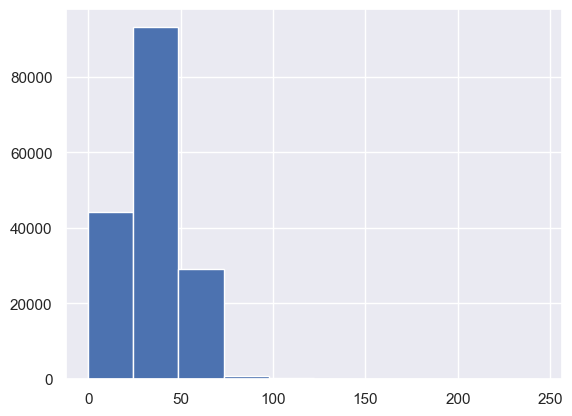

In [8]:
users.Age.hist()

> As with the *books* dataset, we won't be doing any user profiling, so the location and age columns can be disregarded. Were we to use them, they would both require cleaning.

### Ratings CSV<a class="anchor" id="ratings"></a> [&uarr;](#top)

In [9]:
ratings.shape

(1149780, 3)

In [10]:
ratings.head(3)

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0


> The *ratings* dataset contains almost 1.15 million observations. The first two columns give the user and book identifiers. The third and final column gives the rating value.

In [11]:
rating_vals = ratings['Book-Rating'].value_counts().sort_index()

In [12]:
rating_vals

0     716109
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: Book-Rating, dtype: int64

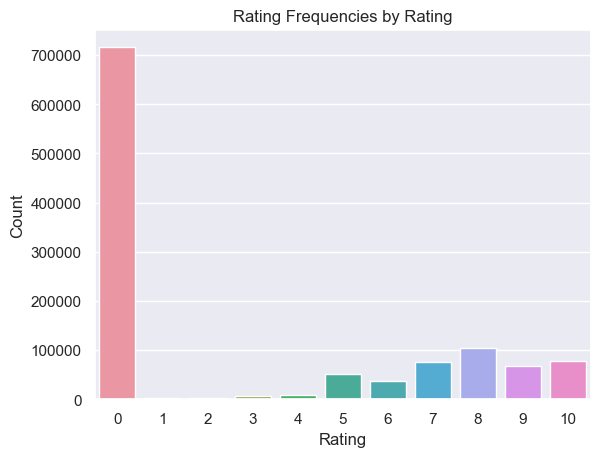

In [13]:
# Check distribution of rating values
#rating_vals.plot.bar()
sns.barplot(x=rating_vals.index,y=rating_vals.values)
plt.title('Rating Frequencies by Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

> The ratings range from 0 to 10. It seems possible that 0 represents a low rating than a lack of rating. Further, most ratings systems start with a minimum score of 1.
> Another possibility is that the users are most inclined to provide a rating when they really dislike a book. However, if this is the case, I would expect an additional peak at the high end and that isn't present here.

### Comparison of Datasets<a class="anchor" id="compare"></a> [&uarr;](#top)

In [14]:
# confirm all users & books in ratings are in their respective dataframes
print(f"All *ratings* users in *users*: {set(ratings['User-ID'].unique()).issubset(users['User-ID'])}")
print(f"All *ratings* books in *books*: {set(ratings.ISBN.unique()).issubset(books.ISBN)}")

All *ratings* users in *users*: True
All *ratings* books in *books*: False


> Uh-oh! The *books* dataset is missing some of the books in the *ratings* datasets

In [15]:
ratings['ISBN'].nunique()

340556

In [16]:
books['ISBN'].nunique()

271360

>Given that we have 340k books in the Ratings dataframe and only 270k books in the Books dataframe (and we don't need the data contained in Books), we will disregard the Books dataframe. The alternative would be to *add* the missing books, but as no data is associated, there is nothing to be gained.  

>Similarly, we won't do anything with the *users* dataset as it offers no utility.

### Applying Adjusted-Sigmoid Transform<a class="anchor" id="sigmoid"></a> [&uarr;](#top)
In a previous project, transforming the user ratings proved very successful for training the NMF model. The transform uses an adjusted sigmoid transform so that the output values are between 1 and 10, rather than 0 and 1.

In [17]:
def sigmap(inflection=5, steepness=1):
    '''
    Scale values to range between 1 and 10
    
    Uses: f(x)1/(1+np.exp((a-x)*b))*9+1
    
    inflection: 5 established as best for this NMF in prior project
    steepness: 1 establist as best for this NMF in prior project
    '''
    return lambda x : 1/(1+np.exp((inflection-x)*steepness))*9+1

# Print original and adjusted values
print(orig_ratings := list(range(1,11)))
print(adj_ratings := list(map(sigmap(),orig_ratings)))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[1.161875889658824, 1.4268328585981012, 2.072826298199058, 3.420472792329956, 5.5, 7.579527207670044, 8.92717370180094, 9.5731671414019, 9.838124110341177, 9.939764341681437]


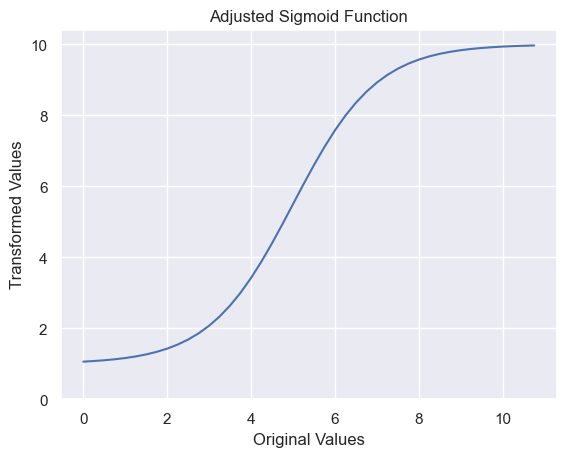

In [18]:
#Sigmoid Plot

input = np.arange(0,11,.25)
plt.style.use("seaborn-v0_8-deep")
output = np.array(list(map(sigmap(),input)))
plt.plot(input, output)
plt.title('Adjusted Sigmoid Function')
plt.xlabel('Original Values')
plt.ylabel('Transformed Values')
plt.ylim(bottom=0)
plt.show()

In [19]:
# create a dictionary with new values for mapping to later
adj_idx = dict(zip(orig_ratings, adj_ratings))

### Cleaning & Creation of New DataFrames<a class="anchor" id="new"></a> [&uarr;](#top)
To prepare data, we will need to remove the zero-ratings and set up training, test, and validation sets that include transformed data as well as a column to show if a recommendation would be given.

In [20]:
# drop zero-ratings
ratings = ratings[ratings['Book-Rating']!=0]
print(f'Now:\n{ratings.shape[0]} unique (non-zero) ratings,\n{len(ratings.ISBN.unique())} unique books, and\n{len(ratings["User-ID"].unique())} unique users')

Now:
433671 unique (non-zero) ratings,
185973 unique books, and
77805 unique users


In [21]:
# create list of unique books
book_list = pd.Series(ratings['ISBN'].unique())
book_list

0          0155061224
1          052165615X
2          0521795028
3          3257224281
4          0600570967
             ...     
185968     0671563149
185969     1575660792
185970     0380796155
185971     0806917695
185972    05162443314
Length: 185973, dtype: object

In [22]:
book_idx = dict(zip(book_list.values, book_list.index))

In [23]:
# create index of unique users
user_list = pd.Series(ratings['User-ID'].unique())
user_idx = dict(zip(user_list.values, user_list.index))

Our new dataframe will use our new indexes and will include a binary column identifying recommendations

In [24]:
df=pd.DataFrame({'uid':ratings['User-ID'].map(user_idx),
                 'bid':ratings['ISBN'].map(book_idx),
                 'rating':ratings["Book-Rating"],
                 'adj':ratings["Book-Rating"].map(adj_idx),
                 'recommend':(ratings["Book-Rating"]>=THRESHOLD).astype(np.int64)})
df.head()

,uid,bid,rating,adj,recommend
1,0,0,5,5.500000,0
3,1,1,3,2.072826,0
4,1,2,6,7.579527,0
6,2,3,8,9.573167,1
7,3,4,6,7.579527,0


In [25]:
# record unique user and book counts
n_users = df.uid.nunique()
n_books = df.bid.nunique()

Here we'll turn our new dataframe into training, validation, and test datasets

In [26]:
test_pct = 0.1 # Use 10% of ratings for each of validation and test sets
test, val, train = np.split(df.sample(frac=1, random_state=seed), 
                            [int(test_pct*len(df)), int(2*test_pct*len(df))])

### Evaluation Function (F1-score)<a class="anchor" id="evaluation"></a> [&uarr;](#top)
- HOW SCORE
- WHY RMSE, FSCORE

In [27]:
def fscore(yp, yt=test.recommend, convert=False, threshold=THRESHOLD):
    if convert==True:
        yp = (yp>=THRESHOLD)
    yp = yp.reshape(-1)
    yp = np.round(yp)
    # True/False Positives & Negatives
    tp = ((yp == 1) & (yt == 1)).sum()
    fp = ((yp == 1) & (yt == 0)).sum()
    fn = ((yp == 0) & (yt == 1)).sum()
    return 2*tp / (2*tp + fp + fn)

# Basic NMF Model (Non Neural-Network)<a class="anchor" id="non-nn"></a> [&uarr;](#top)
I will use on eof my **Non-Negative Matrix Factorization (NMF)** models from an earlier program in this degree to establish a benchmark. This model creates a ratings matrix and employs dot product to calculate the Jaccard similarity of users based off their book ratings.

In [28]:
class NMFReco():
    def __init__(self, X, y):
        self.u = X[0]
        self.b = X[1]
        self.r = y
        self.allbooks = list(df['bid'].unique())
        self.allusers = list(df['uid'].unique())
        self.user_id_idx = dict(zip(self.allusers, list(range(n_users))))
        self.book_id_idx = dict(zip(self.allbooks, list(range(n_books))))
        self.Moo = self.create_ratings_matrix()
        self.Msr = self.Moo.tocsr()
        self.Msc = self.Moo.tocsc()
        self.calc_similarity(self.jac_calc)
        self.avg_rating = np.mean(y)
    
    def create_ratings_matrix(self):
        '''
        Convert ratings from long to wide sparse matrix
        '''
        user_idx = [self.user_id_idx[x] for x in self.u]
        book_idx = [self.book_id_idx[x] for x in self.b]
        return coo_matrix((self.r, (user_idx, book_idx)),shape=(n_users, n_books))   
    
    def calc_similarity(self, simcalc, *Xr):
        '''
        
        '''
        if len(Xr)==0:
            simcalc(self.Moo.copy())
        else:
            simcalc(Xr[0])
    
    def jac_calc(self, X):
        '''
        Calculate Jaccard Similarity between all users (rows)
        (Intersection of A-B / Union of A-B)
        '''
        # intersect/union
        intersect = self.get_all_pairwise_intersect(X)
        union = self.get_pairwise_union(X)

        # invert union values
        union.data = 1/union.data
        jaccard = intersect.multiply(union)
        # remove diagonals
        jaccard.setdiag(0)
        jaccard.eliminate_zeros()
        self.sim = jaccard

    def get_single_pairwise_intersect(self, X, return_bool_matrix=False):
        Xi = X.astype(bool).astype(int)
        if return_bool_matrix==True:
            return Xi.dot(Xi.T), Xi
        else:
            return Xi.dot(Xi.T)
        
    def get_all_pairwise_intersect(self, X):
        # How many ranks/ratings in data
        Xrounded = np.round(X)
        rank_vals = np.unique(X.data)

        # Calc intersect across all rank values
        intersect = csr_matrix((X.shape[0],X.shape[0]))

        for i in rank_vals:
            Xi = (X==i).astype(int)
            inter_i = self.get_single_pairwise_intersect(Xi)
            intersect += inter_i
        return intersect

    def get_pairwise_union(self, X):
        intersect, Xi = self.get_single_pairwise_intersect(
            X, return_bool_matrix=True)
        rownnz = Xi.getnnz(axis=1)
        countM = intersect.astype(bool).astype(int).multiply(rownnz)
        return countM+countM.T-intersect

    def predict_rating(self, user_id, book_id):
        user_idx = self.user_id_idx[user_id]
        book_idx = self.book_id_idx[book_id]
        
        rating_slice = self.Msc.getcol( book_idx)
        sim_slice = self.sim[user_idx]
        
        # sim weights x ratings for this book
        unscaled_pred = sim_slice.dot(rating_slice).sum()

        if unscaled_pred == 0:
            if self.Msr.getrow(user_idx).sum() == 0:
                pred = self.avg_rating
            else:
                pred = self.Msr.getrow(user_idx).data.mean()
        else:
            inv_rating_slice = rating_slice.T.copy()
            inv_rating_slice.data = 1/inv_rating_slice.data
            sim_weights = sim_slice.multiply(
                rating_slice.T).multiply(inv_rating_slice).data.sum()
            pred = unscaled_pred / sim_weights
        return pred
    
    def predict_set(self, predX, roundvals=False):
        m = len(predX[0])
        predy = np.zeros(m)
        for i in range(m):
            user_id = predX[0].iloc[i]
            book_id = predX[1].iloc[i]
            predy[i] = self.predict_rating(user_id,book_id)
        return np.round(predy).astype(int) if roundvals else predy

### Basic NMF Performance<a class="anchor" id="nmf-perf"></a> [&uarr;](#top)
#### Check performance on the Validation Set:

In [29]:
nmf = NMFReco([train.uid, train.bid],train.rating)
pred = nmf.predict_set([val.uid, val.bid])
print(f"Using the ORIGINAL rating data with NMF, we get:\n\
- accuracy of: {((pred>THRESHOLD)==val.recommend.astype('bool')).mean()}\n\
- F1-score of: {fscore(pred,val.recommend, convert=True)}")

C:\Users\jawor\anaconda3\lib\site-packages\scipy\sparse\_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Using the ORIGINAL rating data with NMF, we get:
- accuracy of: 0.603500357414624
- F1-score of: 0.6016244670461853


In [30]:
nmf_adj = NMFReco([train.uid, train.bid],train.adj)
pred_adj = nmf_adj.predict_set([val.uid, val.bid])
print(f"Using the ADJUSTED rating data with NMF, we get:\n\
- accuracy of: {((pred_adj>THRESHOLD)==val.recommend.astype('bool')).mean()}\n\
- F1-score of: {fscore(pred_adj,val.recommend, convert=True)}")

Using the ADJUSTED rating data with NMF, we get:
- accuracy of: 0.6366130929047432
- F1-score of: 0.7379134860050891


> The NMF model fit on the adjusted data had a slightly higher accuracy, but a much higher F1-score. This establishes our **validation benchmark as 0.738**. Moving forward will focus on F1-score as our primary metric.

#### Check performance on the Test Set:

In [31]:
fscore(nmf_adj.predict_set([test.uid, test.bid]),test.recommend, convert=True)

0.7428949764131424

> The adjusted-data NMF model scored similarly well on the test set (looking exclusively at F1-score).

# Neural Network NMF Models<a class="anchor" id="model"></a> [&uarr;](#top)

The Keras models will again rely on a ratings matrix. We will try fitting to using the three variations of the rating data: the original rating, the adjusted rating, and the binary/boolean recommendation.

**Approach**:   
Reproducibility of results in Keras has been a struggle, so only significant improvements in performance will be chased. In other words, the simpler model will be preferred where the complex model only offers a small improvement.

To start we'll define the layers that will be common to all models:

In [32]:
LATENT_DIM = 1 # This is a dimension for the embedding space that we don't need in this case

# tranform the inputted *user* series
user_input = Input(shape=[1], name='user-input')
user_embed = Embedding(n_users + 1, 
                       LATENT_DIM,
                       name='user-embed')(user_input)
user_vec = Flatten(name='user-flatten')(user_embed)

# transform the inputted *book* series
book_input = Input(shape=[1], name='book-input')
book_embed = Embedding(n_books + 1, 
                       LATENT_DIM,
                       name='book-embed')(book_input)
book_vec = Flatten(name='book-flatten')(book_embed)

# create ratings matrix
dot = Dot(axes=1, name='dot')([user_vec, book_vec])

### A Simple First Model<a class="anchor" id="simple"></a> [&uarr;](#top)

#### Original Data

In [33]:
x = Dense(1,name='dense', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed))(dot)

o_simple = Model([user_input, book_input], outputs = x, name="First-Simple-Dot-Product")
o_simple.compile(
        optimizer='adam',
        loss='mean_squared_error')
o_simple.summary()

Model: "First-Simple-Dot-Product"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 book-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user-embed (Embedding)         (None, 1, 1)         77806       ['user-input[0][0]']             
                                                                                                  
 book-embed (Embedding)         (None, 1, 1)         185974      ['book-input[0][0]']             
                                                                           

In [34]:
o_simple.fit([train.uid, train.bid], train.rating, epochs=5,
                validation_data=([val.uid, val.bid], val.rating))
fscore(o_simple.predict([val.uid, val.bid]), val.recommend, convert=True)

Epoch 1/5
10842/10842 [==============================] - 27s 2ms/step - loss: 18.5144 - val_loss: 3.4080
Epoch 2/5
10842/10842 [==============================] - 26s 2ms/step - loss: 3.2872 - val_loss: 3.3501
Epoch 3/5
10842/10842 [==============================] - 26s 2ms/step - loss: 2.9738 - val_loss: 3.4249
Epoch 4/5
10842/10842 [==============================] - 26s 2ms/step - loss: 2.6330 - val_loss: 3.5616
Epoch 5/5
1356/1356 [==============================] - 1s 953us/step


0.36647336641358286

> As expected, loss dropped with more training. However, while the *validation loss* improved after a second epoch of training, further training made it worse. This flags that the model is overfitting. No regularization techniques were incorporated into this mode but should be considered.    
Further, it is not clear that MSE is the best loss metric so MAE will also be evaluated.

In [35]:
x = Dense(1,name='dense', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed))(dot)

o_simple_mae = Model([user_input, book_input], outputs = x, name="First-Simple-Dot-Product")
o_simple_mae.compile(
        optimizer='adam',
        loss='mean_absolute_error')
o_simple_mae.fit([train.uid, train.bid], train.rating, epochs=5,
                validation_data=([val.uid, val.bid], val.rating))
fscore(o_simple_mae.predict([val.uid, val.bid]), val.recommend, convert=True)

Epoch 1/5
10842/10842 [==============================] - 27s 2ms/step - loss: 3.0864 - val_loss: 1.5313
Epoch 2/5
10842/10842 [==============================] - 27s 2ms/step - loss: 1.1075 - val_loss: 1.5353
Epoch 3/5
10842/10842 [==============================] - 26s 2ms/step - loss: 1.0136 - val_loss: 1.5418
Epoch 4/5
10842/10842 [==============================] - 26s 2ms/step - loss: 0.9491 - val_loss: 1.5517
Epoch 5/5
1356/1356 [==============================] - 1s 962us/step


0.41982753762047004

> MAE yielded a strong improvement, though the score is still quite low.

#### Adjusted Data

In [36]:
x = Dense(1,name='dense', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed))(dot)

a_simple = Model([user_input, book_input], outputs = x, name="First-Simple-Dot-Product")
a_simple.compile(
        optimizer='adam',
        loss='mean_squared_error')
a_simple.fit([train.uid, train.bid], train.adj, epochs=5,
                validation_data=([val.uid, val.bid], val.adj))
fscore(a_simple.predict([val.uid, val.bid]), val.recommend, convert=True)

Epoch 1/5
10842/10842 [==============================] - 27s 2ms/step - loss: 22.9673 - val_loss: 4.5800
Epoch 2/5
10842/10842 [==============================] - 26s 2ms/step - loss: 2.5465 - val_loss: 4.2032
Epoch 3/5
10842/10842 [==============================] - 27s 2ms/step - loss: 2.2704 - val_loss: 4.3272
Epoch 4/5
10842/10842 [==============================] - 26s 2ms/step - loss: 2.1158 - val_loss: 4.3932
Epoch 5/5
1356/1356 [==============================] - 1s 950us/step


0.5991524185298845

In [37]:
x = Dense(1,name='dense', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed))(dot)

a_simple_mae = Model([user_input, book_input], outputs = x, name="First-Simple-Dot-Product")
a_simple_mae.compile(
        optimizer='adam',
        loss='mean_absolute_error')
a_simple_mae.fit([train.uid, train.bid], train.adj, epochs=3,
                validation_data=([val.uid, val.bid], val.adj))
fscore(a_simple_mae.predict([val.uid, val.bid]), val.recommend, convert=True)

Epoch 1/3
10842/10842 [==============================] - 27s 2ms/step - loss: 3.4261 - val_loss: 1.6206
Epoch 2/3
10842/10842 [==============================] - 27s 2ms/step - loss: 0.8871 - val_loss: 1.5472
Epoch 3/3
1356/1356 [==============================] - 1s 945us/step


0.6753602580331906

> The adjusted data model saw a much higher fscore, though not yet exceeding the benchmark from the basic NMF. Overfitting again as an issue.   
>It should be noted that the loss here is operating on a different dataset and isn't directly comparable to the loss from the original dataset.

#### Binary Data

In [38]:
x = Dense(1,name='dense', activation='sigmoid',
          kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed))(dot)

b_simple = Model([user_input, book_input], outputs = x, name="First-Simple-Dot-Product")
b_simple.compile(
        optimizer='adam',
        loss='binary_crossentropy')
b_simple.fit([train.uid, train.bid], train.recommend, epochs=5,
                validation_data=([val.uid, val.bid], val.recommend))
fscore(b_simple.predict([val.uid, val.bid]), val.recommend)

Epoch 1/5
10842/10842 [==============================] - 28s 2ms/step - loss: 0.5175 - val_loss: 0.8214
Epoch 2/5
10842/10842 [==============================] - 27s 2ms/step - loss: 0.4447 - val_loss: 0.8758
Epoch 3/5
10842/10842 [==============================] - 26s 2ms/step - loss: 0.4208 - val_loss: 0.9079
Epoch 4/5
10842/10842 [==============================] - 26s 2ms/step - loss: 0.4044 - val_loss: 0.9253
Epoch 5/5
1356/1356 [==============================] - 1s 947us/step


0.5033095915234188

> The F1-score was lower than for the adjusted dataset model. Overfitting was again an issue.

### Preparing for More Complex Models<a class="anchor" id="complex"></a> [&uarr;](#top)
The function below will compile, fit, plot, and evaluatea  model

In [57]:
# helper function for running keras models
def run(model_obj, dataset='adjusted', verbose=0):

    # setup for adjusted-dataset models
    if dataset=='adjusted':
        ytrain = train.adj
        yval = val.adj  
        ylim = (0.5,2) # y-axis limits for plot
        convert = True
        # COMPILE FOR REGRESSION
        model_obj.compile(
            optimizer='adam',
            loss='mean_absolute_error')
    
    # setup for binary-dataset models
    if dataset=='binary':
        ytrain = train.recommend
        yval = val.recommend
        ylim = (0.6,1) # y-axis limits for plot
        convert = False
        # COMPILE FOR 2-CLASS OUTPUT
        model_obj.compile(
            optimizer='adam',
            loss='binary_crossentropy')
        
    # setup for original-dataset models
    if dataset=='original':
        ytrain = train.rating
        yval = val.rating
        ylim = (0.5,2) # y-axis limits for plot
        convert = True
        # COMPILE FOR REGRESSION
        model_obj.compile(
            optimizer='adam',
            loss='mean_absolute_error')
        
    # FIT, ESTABLISH EARLY STOPPING
    hist = model_obj.fit(
        [train.uid, train.bid], ytrain, 
        epochs=25,
        batch_size=128,
        validation_data=([val.uid, val.bid], yval),
        verbose=verbose,
        callbacks=EarlyStopping(
            monitor='val_loss', 
            patience=3,
            min_delta=0.01,
            verbose=1,
            restore_best_weights=True))
    
    # PUT RESULTS IN DATAFRAME
    hist_df = pd.DataFrame(hist.history)
    hist_df.index+=1 # so index matches batch number
    best_batch = hist_df.val_loss.idxmin()
    
    # PLOT METRICS
    epochs = hist_df.shape[0]
    fig, ax = plt.subplots(figsize=(9, 4))
    g = sns.lineplot(
        {"Training":hist_df['loss'],
        "Validation":hist_df['val_loss']}, 
        palette=['b', 'r'], dashes=False)
    g.set(title = "Loss vs Epoch", xlim=(None,None), ylim=ylim)
    g.set_yscale("log")
    #plt.show()   
    
    # PRINT METRICS FROM BEST BATCH
    print(f'All stats: \n{hist_df.loc[[best_batch]]}')   
    print(f"\nValidation set F1-score from best version of model: \
        {fscore(model_obj.predict([val.uid, val.bid],verbose=verbose), val.recommend, convert=convert)}")
    return hist

# initializers
init = tf.keras.initializers.GlorotNormal(seed=seed)

### Adding Dropout<a class="anchor" id="dropout"></a> [&uarr;](#top)

Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping
All stats: 
       loss  val_loss
5  1.186898   1.18489

Validation set F1-score from best version of model:         0.7318849055500322


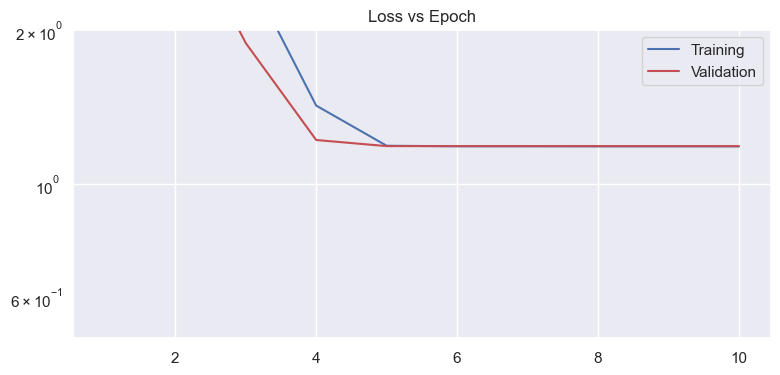

In [40]:
# Adjusted dataset; Dropout only - no additional dense layers
x = Dropout(0.95, seed=seed)(dot)
output = Dense(1, kernel_initializer=init)(x)

a0 = Model([user_input, book_input], outputs = output)
h_a0 = run(a0)

> The dropout value of 0.95 yielded the highest validation F1-score. High dropout values will be the default.

Restoring model weights from the end of the best epoch: 1.
Epoch 6: early stopping
All stats: 
       loss  val_loss
6  0.669754    0.6745

Validation set F1-score from best version of model:         0.7305624331570388


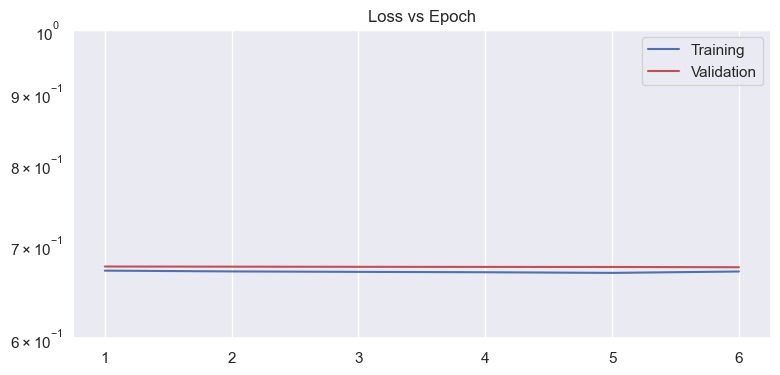

In [41]:
# Binary dataset; Dropout only - no additional dense layers
x = Dropout(0.95, seed=seed)(dot)
output = Dense(1, kernel_initializer=init, activation='sigmoid')(x)

b0 = Model([user_input, book_input], outputs = output)
h_b0 = run(b0, dataset='binary')

Restoring model weights from the end of the best epoch: 4.
Epoch 9: early stopping
All stats: 
       loss  val_loss
9  1.424113  1.436637

Validation set F1-score from best version of model:         0.6000629392636107


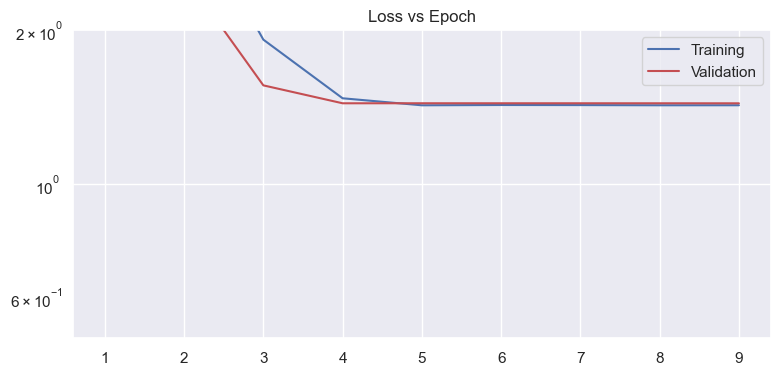

In [42]:
# Original dataset; Dropout only - no additional dense layers
x = Dropout(0.95, seed=seed)(dot)
output = Dense(1, kernel_initializer=init)(x)

o0 = Model([user_input, book_input], outputs = output)
h_o0 = run(o0, dataset='original')

> For the time being, we will focus on the adjusted dataset as it has performed considerably better than the other two datasets

### 1 Dense Mid-Layer<a class="anchor" id="1d"></a> [&uarr;](#top)

Restoring model weights from the end of the best epoch: 5.
Epoch 10: early stopping
All stats: 
       loss  val_loss
6  1.185582  1.184803

Validation set F1-score from best version of model:         0.7318849055500322


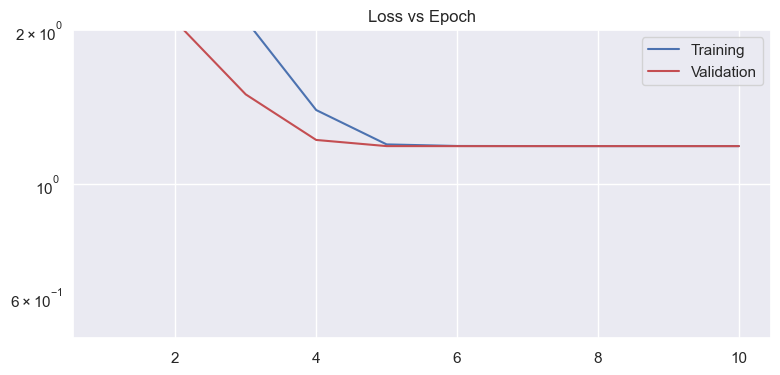

In [43]:
# 32-unit Dense
x = Dropout(0.95, seed=seed)(dot)

x = Dense(32, kernel_initializer=init)(x)
x = Dropout(0.95, seed = seed)(x)

output = Dense(1, kernel_initializer=init)(x)

a1 = Model([user_input, book_input], outputs = output)
ha1 = run(a1)

After exploring further dropout ratio and dense-unit variations (with little F1-score variation), the best model was:

Restoring model weights from the end of the best epoch: 2.
Epoch 7: early stopping
All stats: 
       loss  val_loss
2  1.296036  1.211358

Validation set F1-score from best version of model:         0.7319013291611224


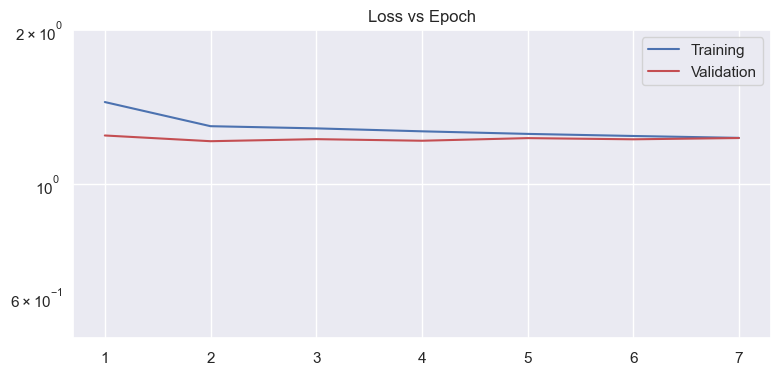

In [49]:
# Much increased unit count, lower dropout
x = Dropout(0.8, seed=seed)(dot)

x = Dense(1024, kernel_initializer=init)(x)
x = Dropout(0.8, seed=seed)(x)

output = Dense(1, kernel_initializer=init)(x)

a1b = Model([user_input, book_input], outputs = output)
ha1b = run(a1b)

> A *very* minor improvement over the previous best model despite major changes.

### 1 Dense Mid-Layer with Activation Function: <a class="anchor" id="activation"></a> [&uarr;](#top)

Restoring model weights from the end of the best epoch: 9.
Epoch 14: early stopping
All stats: 
        loss  val_loss
13  1.114003  1.186608

Validation set F1-score from best version of model:         0.7318800292611558


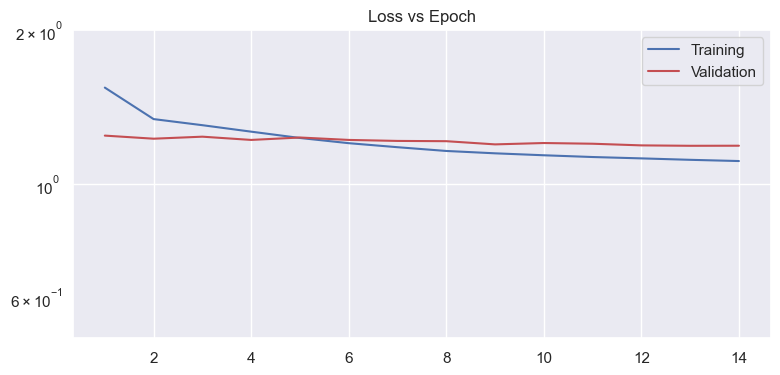

In [50]:
# with RELU ACTIVATION
x = Dropout(0.8, seed=seed)(dot)

x = Dense(1024, kernel_initializer=init, activation='relu')(x)
x = Dropout(0.8, seed=seed)(x)

output = Dense(1, kernel_initializer=init)(x)

a1r = Model([user_input, book_input], outputs = output)
ha1r = run(a1r)

Restoring model weights from the end of the best epoch: 7.
Epoch 12: early stopping
All stats: 
       loss  val_loss
8  1.238257  1.201004

Validation set F1-score from best version of model:         0.7318934885285215


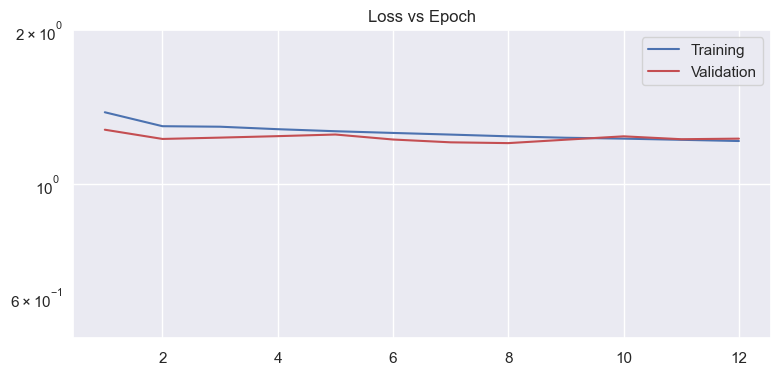

In [51]:
# with SIGMOID ACTIVATION
x = Dropout(0.8, seed=seed)(dot)

x = Dense(1024, kernel_initializer=init, activation='sigmoid')(x)
x = Dropout(0.8, seed=seed)(x)

output = Dense(1, kernel_initializer=init)(x)

a1s = Model([user_input, book_input], outputs = output)
ha1s = run(a1s)

> Neither of the activations improved the model. We won't include these activations moving forward.

### 2 Dense Mid-Layers<a class="anchor" id="2d"></a> [&uarr;](#top)

Restoring model weights from the end of the best epoch: 1.
Epoch 6: early stopping
All stats: 
       loss  val_loss
1  1.418464  1.288556

Validation set F1-score from best version of model:         0.7322797775826748


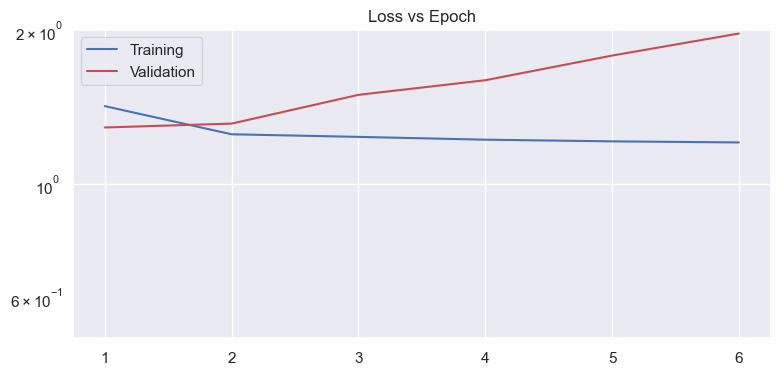

In [52]:
x = Dropout(0.8, seed=seed)(dot)

x = Dense(1024, kernel_initializer=init)(x)
x = Dropout(0.8, seed=seed)(x)

x = Dense(1024, kernel_initializer=init)(x)
x = Dropout(0.8, seed=seed)(x)

output = Dense(1, kernel_initializer=init)(x)

a2 = Model([user_input, book_input], outputs = output)
ha2 = run(a2)

Further exploration yielded:

Restoring model weights from the end of the best epoch: 1.
Epoch 6: early stopping
All stats: 
       loss  val_loss
1  1.639872   1.48753

Validation set F1-score from best version of model:         0.7325508125613635


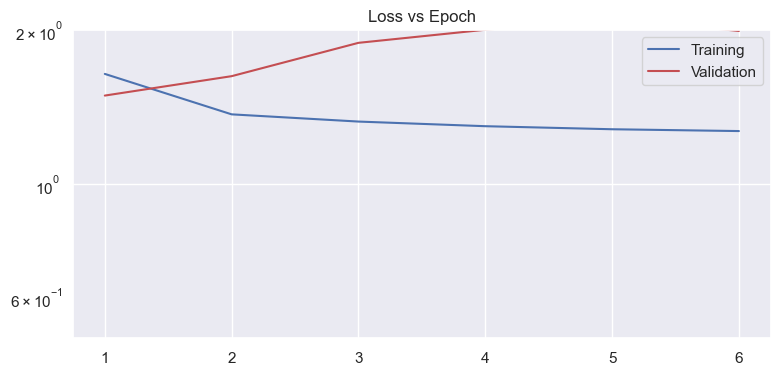

In [54]:
x = Dropout(0.9, seed=seed)(dot)

x = Dense(1024, kernel_initializer=init)(x)
x = Dropout(0.9, seed=seed)(x)

x = Dense(1024, kernel_initializer=init)(x)
x = Dropout(0.9, seed=seed)(x)

output = Dense(1, kernel_initializer=init)(x)

a2b = Model([user_input, book_input], outputs = output)
ha2b = run(a2b)

Restoring model weights from the end of the best epoch: 11.
Epoch 16: early stopping
All stats: 
        loss  val_loss
11  1.326815  1.203941

Validation set F1-score from best version of model:         0.7318849055500322


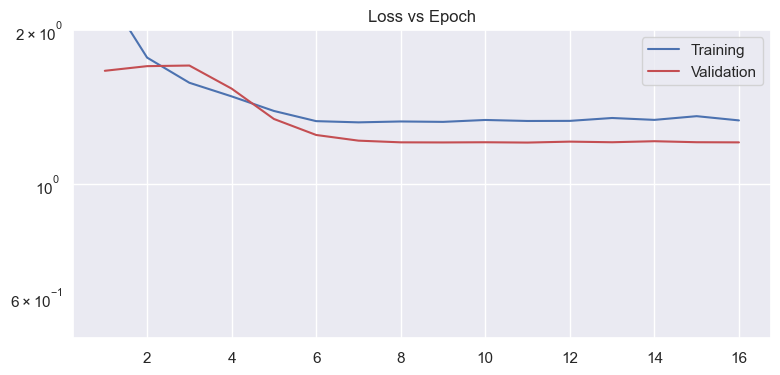

In [56]:
x = Dropout(0.97, seed=seed)(dot)

x = Dense(1024, kernel_initializer=init)(x)
x = Dropout(0.97, seed=seed)(x)

x = Dense(1024, kernel_initializer=init)(x)
x = Dropout(0.97, seed=seed)(x)

output = Dense(1, kernel_initializer=init)(x)

a2b = Model([user_input, book_input], outputs = output)
ha2b = run(a2b)

Restoring model weights from the end of the best epoch: 5.
Epoch 8: early stopping
All stats: 
       loss  val_loss
7  1.174878  1.185879

Validation set F1-score from best version of model:         0.7318849055500322


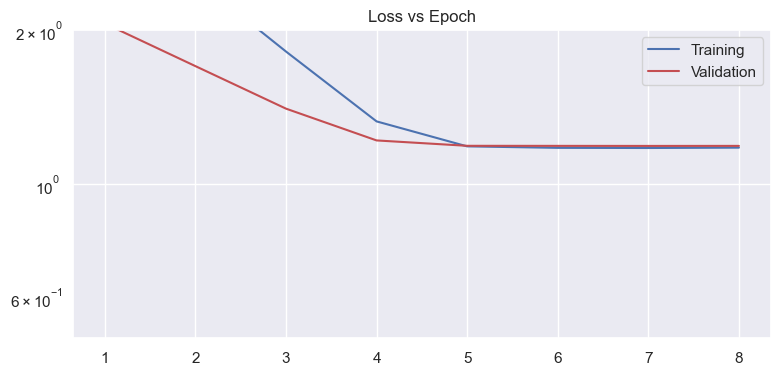

In [59]:
x = Dropout(0.9, seed=seed)(dot)

x = Dense(256, kernel_initializer=init)(x)
x = Dropout(0.9, seed=seed)(x)

x = Dense(32, kernel_initializer=init)(x)
x = Dropout(0.9, seed=seed)(x)

output = Dense(1, kernel_initializer=init)(x)

a2b = Model([user_input, book_input], outputs = output)
ha2b = run(a2b)

> The results so far don't suggest that adding layers or further tweaking parameters will yield a signficantly better model. Nor did using high-unit count models.
# Neural-Network NMF with Skip<a class="anchor" id="skip"></a> [&uarr;](#top)
With these models we will pass the original inputs as well as their ratings matrix product into the model. This could provide some advantage over a standard NMF model.

Restoring model weights from the end of the best epoch: 5.
Epoch 8: early stopping
All stats: 
       loss  val_loss
5  1.185607  1.185066

Validation set F1-score from best version of model:         0.7318849055500322


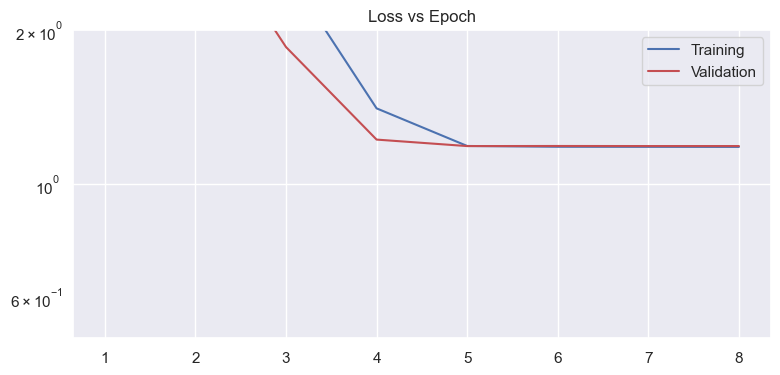

In [60]:
x = Concatenate()([dot, book_vec, user_vec])
x = Dropout(0.95, seed=seed)(x)

output = Dense(1, kernel_initializer=init)(x)

s0 = Model([user_input, book_input], outputs = output)
hs0 = run(s0)

> No improvement over non-skip model - will look at adding the inputs back in with dense layers.

### 1 Dense Mid-Layer with Skip<a class="anchor" id="1s"></a> [&uarr;](#top)

Restoring model weights from the end of the best epoch: 5.
Epoch 8: early stopping
All stats: 
       loss  val_loss
8  1.175478  1.184011

Validation set F1-score from best version of model:         0.7318849055500322


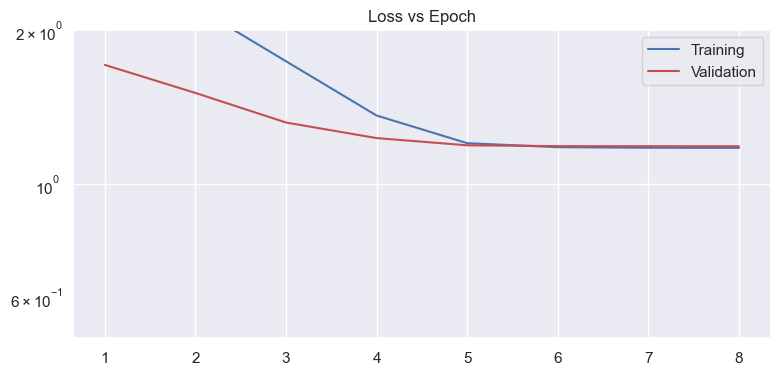

In [62]:
# SKIP-DENSE
x = Concatenate()([dot, book_vec, user_vec])
x = Dropout(0.9, seed=seed)(x)

x = Dense(64, kernel_initializer=init)(x)
x = Dropout(0.9, seed=seed)(x)

output = Dense(1, kernel_initializer=init)(x)

s1 = Model([user_input, book_input], outputs = output)
hs1 = run(s1)

Restoring model weights from the end of the best epoch: 5.
Epoch 8: early stopping
All stats: 
       loss  val_loss
8  1.173558  1.182947

Validation set F1-score from best version of model:         0.7318849055500322


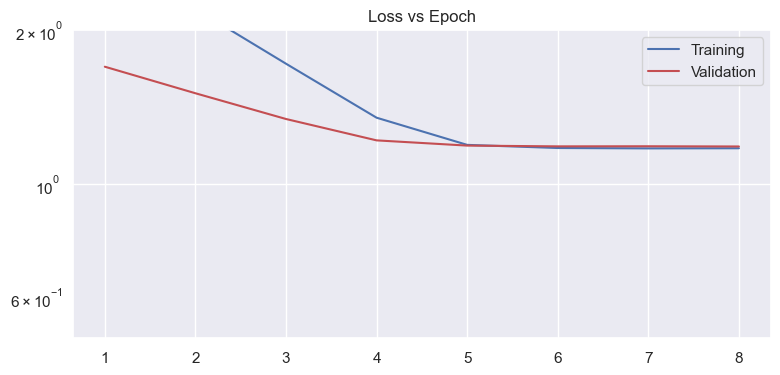

In [63]:
# DENSE-SKIP
x = Dropout(0.9, seed=seed)(dot)

x = Dense(64, kernel_initializer=init)(x)
x = Concatenate()([x, book_vec, user_vec])
x = Dropout(0.9, seed=seed)(x)

output = Dense(1, kernel_initializer=init)(x)

s1b = Model([user_input, book_input], outputs = output)
hs1b = run(s1b)

> Neither skip architecture yielded an improvement

### 2 Dense Mid-Layers with Skip<a class="anchor" id="2s"></a> [&uarr;](#top)

Restoring model weights from the end of the best epoch: 5.
Epoch 8: early stopping
All stats: 
       loss  val_loss
7  1.176849  1.184002

Validation set F1-score from best version of model:         0.7318849055500322


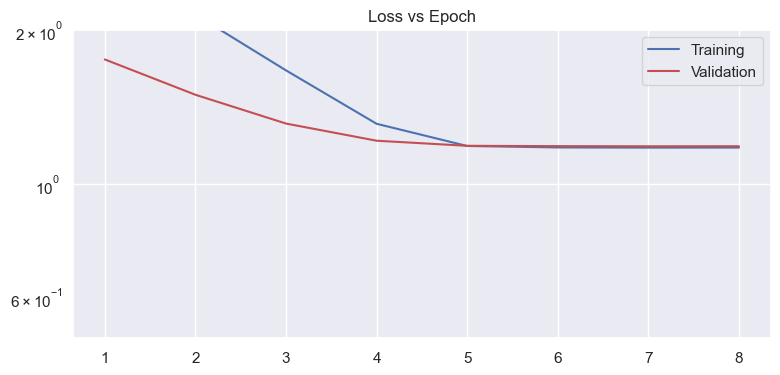

In [64]:
# 2 Dense layer with skip (Dense-Skip-Dense)
x = Dropout(0.9, seed=seed)(dot)

x = Dense(256, kernel_initializer=init)(x)
x = Concatenate()([x, book_vec, user_vec])
x = Dropout(0.9, seed=seed)(x)

x = Dense(64, kernel_initializer=init)(x)
x = Dropout(0.9, seed=seed)(x)

output = Dense(1, kernel_initializer=init)(x)

s2 = Model([user_input, book_input], outputs = output)
hs2 = run(s2)

> We seem to be stuck at the same set of results regardless of architecture. Instead we will look at alternate transforms of the the data.
# NN NMF with Tuned Data Adjustment<a class="anchor" id="tune"></a> [&uarr;](#top)


******
For inflection=4 and steepness=0.5:



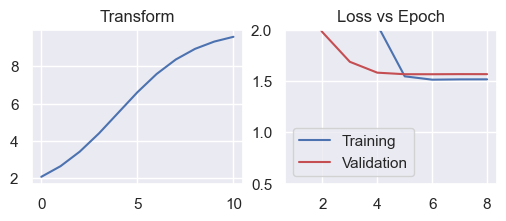

All stats: 
     loss  val_loss
6  1.5143  1.567158

Validation set F1-score from best version of the (4, 0.5) model:             0.7317879341864717


******
For inflection=4 and steepness=1.5:



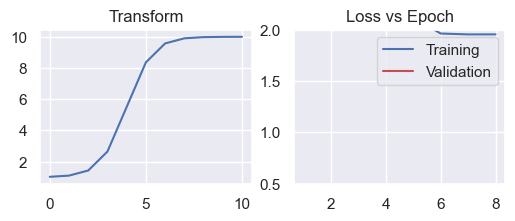

All stats: 
       loss  val_loss
6  1.963881  2.010632

Validation set F1-score from best version of the (4, 1.5) model:             0.7318849055500322


******
For inflection=4 and steepness=2.5:



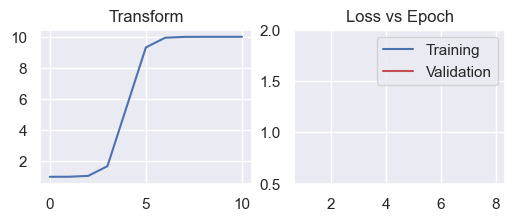

All stats: 
       loss  val_loss
6  2.095346  2.122052

Validation set F1-score from best version of the (4, 2.5) model:             0.7318849055500322


******
For inflection=5 and steepness=0.5:



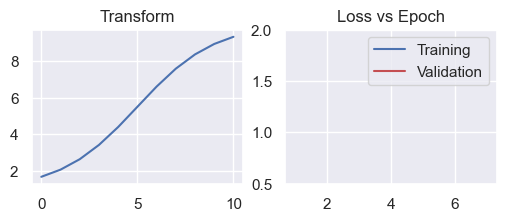

All stats: 
       loss  val_loss
5  2.150714  2.235676

Validation set F1-score from best version of the (5, 0.5) model:             0.011712103826217703


******
For inflection=5 and steepness=1.5:



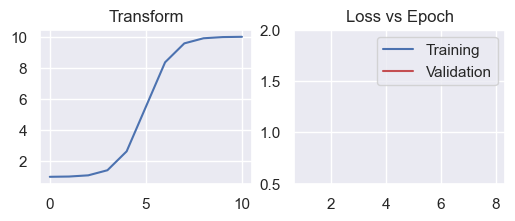

All stats: 
       loss  val_loss
6  4.187239  4.292841

Validation set F1-score from best version of the (5, 1.5) model:             0.7318592612090901


******
For inflection=5 and steepness=2.5:



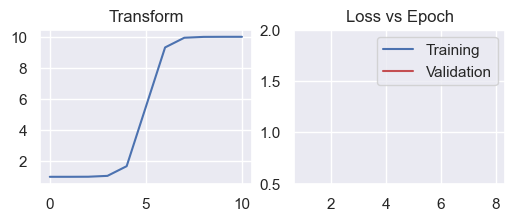

All stats: 
       loss  val_loss
6  4.687929   4.79616

Validation set F1-score from best version of the (5, 2.5) model:             0.7318671034160037


******
For inflection=6 and steepness=0.5:



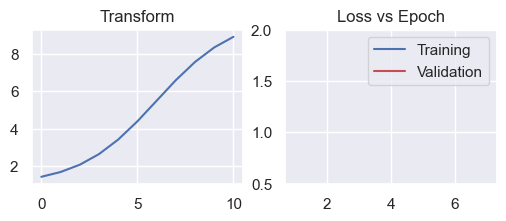

All stats: 
      loss  val_loss
4  2.87435   2.83057

Validation set F1-score from best version of the (6, 0.5) model:             0.0


******
For inflection=6 and steepness=1.5:



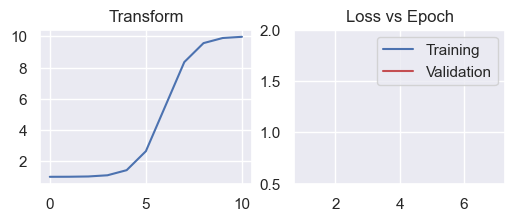

All stats: 
       loss  val_loss
6  7.579153  7.763511

Validation set F1-score from best version of the (6, 1.5) model:             0.24167702269605598


******
For inflection=6 and steepness=2.5:



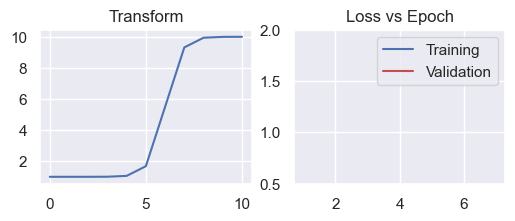

All stats: 
       loss  val_loss
6  9.623998   9.82734

Validation set F1-score from best version of the (6, 2.5) model:             0.4857952408415035



In [103]:
best_fscore = 0
best_model = None
best_hist = None

for inflection in [4, 5, 6]:
    for steepness in [0.5, 1.5, 2.5]:
        
        new_adj_ratings = list(map(sigmap(inflection, steepness),orig_ratings))
        new_adj_idx = dict(zip(orig_ratings, new_adj_ratings))
        ytrain = train.rating.map(new_adj_idx)
        yval = val.rating.map(new_adj_idx)            

        print(f"\n******\nFor inflection={inflection} and steepness={steepness}:\n")
        
        # 2-Layer with Skip
        x = Dropout(0.9, seed=seed)(dot)
        x = Dense(256, kernel_initializer=init)(x)
        x = Concatenate()([x, book_vec, user_vec])
        x = Dropout(0.9, seed=seed)(dot)
        x = Dense(64, kernel_initializer=init)(x)
        x = Dropout(0.9, seed = seed)(x)
        output = Dense(1, kernel_initializer=init)(x)
        model = Model([user_input, book_input], outputs = output)
        
        # COMPILE FOR REGRESSION
        model.compile(
            optimizer='adam',
            loss='mean_squared_error') # seemed to yield more variety
        
        # FIT, ESTABLISH EARLY STOPPING
        hist = model.fit(
            [train.uid, train.bid], ytrain, 
            epochs=25,
            batch_size=128,
            validation_data=([val.uid, val.bid], yval),
            verbose=0,
            callbacks=EarlyStopping(
                monitor='val_loss', 
                patience=3,
                min_delta=0.01,
                verbose=0,
                restore_best_weights=True))
    
        # PUT RESULTS IN DATAFRAME
        hist_df = pd.DataFrame(hist.history)
        hist_df.index+=1 # so index matches batch number
        best_batch = hist_df.val_loss.idxmin()
        
        # PLOT TRANSFORM AND LOSS METRICS
        f, axes = plt.subplots(1, 2, figsize=(6,2))
        sns.lineplot(x=orig_ratings, y=new_adj_ratings, 
                      ax=axes[0]).set(title = "Transform",)
        sns.lineplot(
            {"Training":hist_df['loss'],
            "Validation":hist_df['val_loss']}, 
            palette=['b', 'r'], dashes=False, ax=axes[1]).set(
                title = "Loss vs Epoch", ylim=(0.5,2))
        plt.show() 

        # PRINT METRICS FROM BEST BATCH
        thisfscore = fscore(model.predict([val.uid, val.bid],verbose=0), val.recommend, convert=True)
        print(f'All stats: \n{hist_df.loc[[best_batch]]}')   
        print(f"\nValidation set F1-score from best version of the {inflection, steepness} model: \
            {thisfscore}\n")
        if thisfscore>best_fscore:
            best_model=model
            best_hist=hist

> Frustratingly, the best predictions outputted by the various models is seemingly quite similar, resulting in similar F1-scores. Changing the data transform wasn't as effective as hoped. Additional trials with values closer to the original (since removed for clarity) yielded consistent results.

# Results on Test Dataset<a class="anchor" id="results"></a> [&uarr;](#top)



In [110]:
results = []

results.append(fscore(nmf.predict_set([test.uid, test.bid]),test.recommend, convert=True))
results.append(fscore(nmf_adj.predict_set([test.uid, test.bid]),test.recommend, convert=True))
results.append(fscore(o0.predict([test.uid, test.bid],verbose=0), test.recommend, convert=True))
results.append(fscore(a0.predict([test.uid, test.bid],verbose=0), test.recommend, convert=True))
results.append(fscore(b0.predict([test.uid, test.bid],verbose=0), test.recommend, convert=False))
results.append(fscore(a2b.predict([test.uid, test.bid],verbose=0), test.recommend, convert=True))

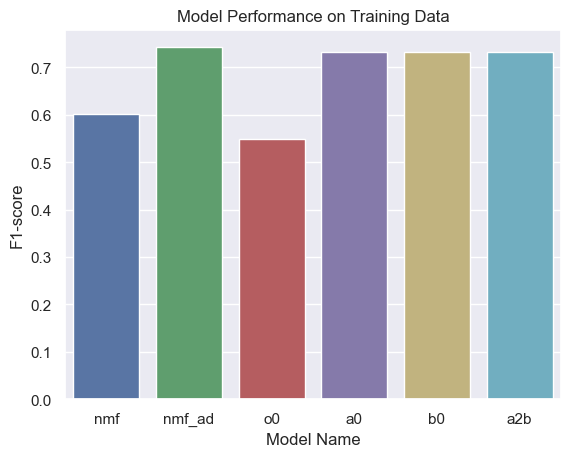

,model,fscore,notes
0,nmf,0.601724,NMF - original data
1,nmf_ad,0.742895,NMF - adjusted data
2,o0,0.549578,NN - original data - dropout
3,a0,0.732941,NN - adjusted data - dropout
4,b0,0.732913,NN - binary/thresholded data - dropout


In [116]:
rdf=pd.DataFrame({'model':['nmf','nmf_ad','o0','a0','b0','a2b'],
                  'fscore':results,
                  'notes':['NMF - original data',
                           'NMF - adjusted data',
                           'NN - original data - dropout',
                           'NN - adjusted data - dropout',
                           'NN - binary/thresholded data - dropout',
                           'NN - adjusted data - 2 hidden layers & dropout']})

sns.barplot(data=rdf, x='model',y='fscore')
plt.title('Model Performance on Training Data')
plt.xlabel('Model Name')
plt.ylabel('F1-score')
plt.show()

rdf.head()

# Conclusion<a class="anchor" id="conclusion"></a> [&uarr;](#top)
The neural-network based recommenders evaluated in this project couldn't outperform the non-neural network models. The biggest improvement over the basic NMF model came from applying a data transform: using a sigmoid-transform in both non-NN and NN based models and using a threshold in another NN model.

One advantage the non-NN NMF models have is an explicit instruction to rate a book by a user's average rating when no similar users are present (for example, a book not rated in the training set). This is a very fringe case but could be what gave the *nmf_ad* model (the non-NN NMF using adjusted data) the edge.

It is important to remind that performance in this project was by thresholding the predicted values and computing an F1-score. Thus, it isn't that the neural networks weren't better at predictions - just that they weren't as good at these suggestions.

One issue with training the neural networks on the adjusted data is that the loss function was still focused on prediction performance and couldn't optimize for F1-score. However the thresholded/binary model was able to optimize for the target data (thresholded values) directly. In comparable tests, both yielded similar results suggests that a targeted transform is a useful technique whether the NMF involves a neural network or not.

Although this project has exhausted the options within its scope, further improvements to this recommender could be explored by alternative threshold NNs or, perhaps a better idea, alternative foundations to the recommender system outside of NMF.


# References<a class="anchor" id="references"></a> [&uarr;](#top)

#### Resources:
[Keras Layers API](https://keras.io/api/layers/)

[How to Get Reproducible Results when Running Keras with Tensorflow Backend](https://saturncloud.io/blog/how-to-get-reproducible-results-when-running-keras-with-tensorflow-backend/)

#### Data:
[Book-Crossing Dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/),
assembled as part of:

[Improving Recommendation Lists Through Topic Diversification](http://www2.informatik.uni-freiburg.de/~dbis/Publications/05/WWW05.html),
Cai-Nicolas Ziegler, Sean M. McNee, Joseph A. Konstan, Georg Lausen; Proceedings of the 14th International World Wide Web Conference (WWW '05), May 10-14, 2005, Chiba, Japan. To appear.